# Question 1

Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as scs

import matplotlib.pyplot as plt
import seaborn as sns

import sqlite3

In [2]:
def test_normality(x):
    """
    h0: x is normal
    ha: x is not normal
    
    if pvalue < 0.5 
        we reject the null hypothesis and our data is not normal
    if pvalue > 0.5
        we fail to rejrect the null hypothesis and our data is normal
    """
    t, p = scs.shapiro(x)
    if p < 0.5:
        print(f"Data is not normal with \npvalue={p}")
        return False
    else:
        print(f"Data is normal with \npvalue={p}")
        return True

In [3]:
conn = sqlite3.connect("./Northwind_small.sqlite")

In [4]:
cursor = conn.cursor()

In [5]:
res = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
res

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

In [6]:
query = "select * from orderdetail"

df = pd.read_sql(query, conn)
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [7]:
df["Discount"].unique()

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 , 0.02, 0.03, 0.04, 0.06, 0.01])

### Let's just test discount vs non-discount

In [8]:
has_discount = []

for discount in df["Discount"]:
    if discount > 0.0:
        has_discount.append(1)
    else:
        has_discount.append(0)
    

In [9]:
df["HasDiscount"] = has_discount
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,HasDiscount
0,10248/11,10248,11,14.0,12,0.0,0
1,10248/42,10248,42,9.8,10,0.0,0
2,10248/72,10248,72,34.8,5,0.0,0
3,10249/14,10249,14,18.6,9,0.0,0
4,10249/51,10249,51,42.4,40,0.0,0


//anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


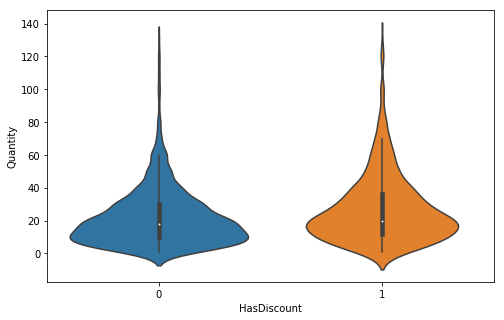

In [10]:
plt.figure(figsize=(8, 5))
sns.violinplot(x='HasDiscount', y='Quantity', data=df)
plt.show()

### Violin Plot Summary
both plots look very similar. I think discount will have a small effect on quantity

### To test if there is a difference in the mean quantity sold by discount type.   

In order to do this, we need to use a **independent ttest*

The assumptions of this test are:
- [x] Our two samples are independent of one another
- Our samples are normally distributed
- Our samples have equal variance -> student ttest
- Our samples have unequal varaince -> welch's ttest

### Let's test for normality using a Shapiro test

In [11]:
discounts = df.loc[df["HasDiscount"]==1, "Quantity"]
non_discounts = df.loc[df["HasDiscount"]==0, "Quantity"]

In [12]:
test_normality(discounts)

Data is not normal with 
pvalue=6.88120409395894e-26


False

In [13]:
test_normality(non_discounts)

Data is not normal with 
pvalue=3.803856556577728e-34


False

In [14]:
discounts.shape[0]

838

### We need normality, so we're going to use sampling distributions

In [15]:
discount_sample_means = []
non_discount_sample_means = []

for sample_number in range(100):
    # I'm using bootstrap sampling
    dis_samp = np.random.choice(discounts, size=discounts.shape[0], replace=True).mean()
    non_dis_samp = np.random.choice(non_discounts, size=non_discounts.shape[0], replace=True).mean()
    
    discount_sample_means.append(dis_samp)
    non_discount_sample_means.append(non_discount_sample_means)

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(discount_sample_means, alpha=0.5, color='b', label="Discounts")
plt.hist(non_discount_sample_means, alpha=0.5, color='r', label="Non Discounts")
plt.legend()
plt.title("Sampling Distributions")
plt.xlabel("Means of Quantity")
plt.show()